# SETUP

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import torch
from tqdm import tqdm, trange
from transformers import AutoModel
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import random


Using TensorFlow backend.


In [2]:
# GPU check
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1050 Ti


# FUNCTIONS

In [3]:
"""
For dealing with large amounts of data, a GPU is much faster

The resulting embedding matrix is a three-dimensional tensor corresponding to                 [Sentence][Words][Embeddings]
embeddings[5][4][:] is thus the embedding of the fourth word in the fifth sentence
"""

def get_embeddings_with_gpu(data_matrix, mask_matrix):
    # Load the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Set the model to use the device
    model.cuda()

    # Move the data onto the GPU
    data_matrix = data_matrix.to(device)
    mask_matrix = mask_matrix.to(device)

    # Generate embeddings
    matrix_embedding = model.forward(input_ids=data_matrix,
        attention_mask=mask_matrix,
        head_mask=None)[0]
    #print(f"Embedding generated with shape {batch_embedding.shape}")

    # Make it an ordinary np array instead of a torch
    matrix_embedding = np.array(matrix_embedding.tolist())

    return matrix_embedding

#Keep amount of samples low to not overwhelm the gpu
#get_embeddings_with_gpu(data_tensor_matrix[:10], mask_tensor_matrix[:10])

In [4]:
"""
Most people won't be able to load all the data onto the GPU at once however, so it's better   to do it in batches.
(50 input sentences take 2803MB on my computer, for example). Though this depends on the dimensionality/sentence_length you use, naturally

This method batchifies and stitches together the batches
"""
def get_embeddings_with_gpu_batch(data_matrix, mask_matrix, batch_size):
    num_items = data_matrix.shape[0]
    num_loops = int(np.ceil(num_items/batch_size))

    start = 0
    end = batch_size
    data_holder = []

    for i in trange(num_loops):
        # Split the data into batches
        data_batch = data_matrix[start:end]
        mask_batch = mask_matrix[start:end]

        #Get the embedding for the batch
        batch_embedding = get_embeddings_with_gpu(data_batch, mask_batch)

        data_holder.append(batch_embedding)

        #Move to next batch
        start += batch_size
        end += batch_size

    # Merge the batches we've generated
    embedding_matrix = np.vstack(data_holder)

    print(f"Final embedding generated with shape {embedding_matrix.shape}")

    return embedding_matrix

#embedding_matrix = get_embeddings_with_gpu_batch(data_tensor_matrix[:200], mask_tensor_matrix[:200], 50)


In [5]:
"""
Split data into train and test sets by the given ratio.
Validation sets are not needed, those we get for free with keras models

"""
def split_data(percentage_to_train_on, input_data, output_data):
    ratio = percentage_to_train_on

    split = int(np.ceil(ratio*input_data.shape[0]))

    train_x = input_data[:split]
    train_y = output_data[:split]

    test_x = input_data[split:]
    test_y = output_data[split:]

    return train_x, train_y, test_x, test_y


def shuffle_data(things_to_shuffle):
    """
    Takes a list of lists and shuffles them all in the same way
    """
    #Set seed for reproducibility
    random.seed(2020)
    
    # Create a list of indices based on the input data
    indices = [i for i in range(things_to_shuffle[0].shape[0])]

    #Shuffle the indices
    random.shuffle(indices)

    shuffled_lists = []
    #For each list,
    for thing_to_shuffle in things_to_shuffle:
        #Reorder the list according to the shuffled indices
        shuffled = np.array([thing_to_shuffle[i] for i in indices])
        shuffled_lists.append(shuffled)
    return shuffled_lists

In [6]:
def generate_embedding_file(sentences, attentions):
    """
    A method needed when we can't keep the entire embedding matrix in ram, such as when generating the embeddings for the whole suc3 dataset.
    
    A 70000 * 100 * 768 matrix of float 64s take like, 50GB.
    
    So instead of trying to keep all that in RAM, this function creates an array on disk to store the embedding in.
    
    On my laptop, this took half an hour and 50 gb of memory
    
    """
    #CREATE MEMORY-MAPPED-OBJECT
    
    #Define the shape of the array
    embedding_matrix_shape = (np.load("../data/sentence_ints.npy").shape[0], np.load("../data/sentence_ints.npy").shape[1], 768)

    #Select the type of the data we will store.
    data_type = np.float64

    #Make space for it on disk
    f = np.memmap('../data/MMAP_MATRIX.dat', dtype=data_type,
                  mode='w+', shape=embedding_matrix_shape)


    #GENERATE EMBEDDINGS AND STORE IN OBJECT
    #Convert to tensors
    sentences, attentions = torch.tensor(sentences), torch.tensor(attentions)
    
    num_batches = 10
    batch_size = int(np.ceil(sentences.shape[0]/num_batches))
    for i in range(0, num_batches):
        #Define slice to generate embedding for
        start = batch_size * i
        end = batch_size * (i+1)
        
        #Generate the batch
        sentence_batch = sentences[batch_size * i : batch_size * (i + 1)]
        attention_batch = attentions[batch_size * i : batch_size * (i + 1)]
                
        # store it in the memmap object
        #Do it directly, if you save it as a reference the memory will still run out during the for loop
        f[start:end, :, :] = get_embeddings_with_gpu_batch(sentence_batch, attention_batch, 25)
        print(f"Stored sentence embedding {start} to {end}")


#generate_embedding_file(sentences, attentions)

In [7]:
def store_one_hot_encoded_labels_file(one_hot_labels):
    """
    For convenience, store the labels on disk as well. 
    No need to burn ram unneccessarily
    """
    #CREATE MEMORY-MAPPED-OBJECT
    
    #Select the type of the data we will store.
    data_type = np.uint8

    #Make space for it on disk
    g = np.memmap('../data/ONE_HOT_LABELS.dat', dtype=data_type,
                  mode='w+', shape=one_hot_labels.shape)
    
    g[:,:,:] = one_hot_labels
    

#store_one_hot_encoded_labels_file(label_matrix)

In [8]:
def get_label_file():
    #Select the type of the data we will store.
    data_type = np.uint8

    g = np.memmap('../data/ONE_HOT_LABELS.dat', dtype=data_type, shape=(74165, 100, 33))
    
    return g
    

In [9]:
def get_embed_file():
    #CREATE MEMORY-MAPPED-OBJECT
    
    #Define the shape of the array
    embedding_matrix_shape = (np.load("../data/sentence_ints.npy").shape[0], np.load("../data/sentence_ints.npy").shape[1], 768)
#    embeddiding_matrix_shape= (sentences.shape[0], sentences.shape[1], 768)

    #Select the type of the data we will store.
    data_type = np.float64

    #Make space for it on disk
    f = np.memmap('../data/MMAP_MATRIX.dat', dtype=data_type, shape=embedding_matrix_shape)
    return f

-0.031509991735219955

# LOAD DATA

In [73]:
#This is the latest!
def load_data_from_start2():
    #Load the data
    sentences = np.load("../data/sentence_ints.npy")
    attentions = np.load("../data/attention_ints.npy")
    labels = np.load("../data/label_ints.npy")
    label_list = np.load("../data/label_list.npy")
    return sentences, attentions, labels, label_list

sentences, attentions, labels, label_list = load_data_from_start2()


In [12]:
# Load the model and tokenizer
model = AutoModel.from_pretrained('KB/albert-base-swedish-cased-alpha')
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#Update the tokenizer with our labels (which do not exist in the normal vocabulary)
tokenizer.add_tokens(label_list.tolist())

#Inform the model that we've updated the vocab
model.resize_token_embeddings(len(tokenizer))

Embedding(50030, 128)

In [74]:
#Shuffle the data
shuffled = shuffle_data([sentences, attentions, labels])
sentences, attentions, labels = shuffled[0], shuffled[1], shuffled[2]

#WARNING, CAREFUL
#Permanently store it
#generate_embedding_file(sentences, attentions)

In [75]:
#We need to one-hot encode the output labels for use with the classifier

#Flatten the label matrix
long_single_token_label_list = labels.reshape(-1,)

#one-hot encode all labels
dummy_variable_representation = pd.get_dummies(long_single_token_label_list)

#Make a dummy-variable-index => token dict for later use
dummyIndex_label_dict = {}
for i, column in enumerate(dummy_variable_representation):
    dummyIndex_label_dict[i] = tokenizer.decode(column)
    

#Reshape the one-hot encoding so we get it in the correct shape, that is, grouped on a sentence level
label_matrix = dummy_variable_representation.values.reshape(labels.shape[0], labels.shape[1], -1)

In [13]:
sentences, attentions = torch.tensor(sentences), torch.tensor(attentions)
embedding_matrix = get_embeddings_with_gpu_batch(sentences, attentions, 25)
get_embed_file()[:5000, :, :]

100%|██████████| 400/400 [02:44<00:00,  2.44it/s]


Final embedding generated with shape (10000, 100, 768)


In [70]:
embedding_matrix = get_embed_file()
label_matrix = get_label_file()

In [80]:
label_matrix == get_label_file()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [71]:
#Train/test split it
ratio = 0.8

train_x,train_y,test_x,test_y = split_data(ratio, embedding_matrix[:10000], label_matrix[:10000])

print(train_y.shape, test_y.shape)
print(train_x.shape, test_x.shape)

(8000, 100, 33) (2000, 100, 33)
(8000, 100, 768) (2000, 100, 768)


NameError: name 'train_x' is not defined

# TRAIN ALBERT

### Create classification layer

To ablate the fine-tuning approach, we apply the
feature-based approach by extracting the activations from one or more layers without fine-tuning
any parameters of BERT. These contextual embeddings are used as input to a randomly initialized two-layer 768-dimensional BiLSTM before
the classification layer.



In [45]:
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout, Dense
from keras.models import Model, Input
def naive_bilstm_model():   
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(train_x.shape[1], train_x.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
            
    # add a timedistributed layer
    out = TimeDistributed(Dense(train_y.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model


In [72]:
# Train the model, setting aside 10% data for validation
classifier = naive_bilstm_model()
def train_model():
    history = classifier.fit(
        train_x,
        train_y,
        epochs=3,
        batch_size=50,
        validation_split=0.1)
    return history

history = train_model()
print('\nhistory dict:', history.history.keys())

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100, 768)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 100, 33)           6633      
Total params: 701,833
Trainable params: 701,833
Non-trainable params: 0
_________________________________________________________________
None
Train on 7200 samples, validate on 800 samples
Epoch 1/3
7200/7200 [==============================] - 31s 4ms/step - loss: 0.5776 - accuracy: 0.8427 - val_loss: 0.4453 - val_accuracy: 0.8667
Epoch 2/3
7200/7200 [==============================] - 31s 4ms/step - loss: 0.4322 - accuracy: 0.8700 - val_loss: 0.4377 - val_accuracy: 0.8674
Epoch 3/3
7200/7200 [=====================

## Training history

In [47]:
def create_history_df(history):
    training_df = pd.DataFrame()
    for metric in history.history.keys():
        training_df[metric] = history.history[metric]
    return training_df

history_df = create_history_df(history)

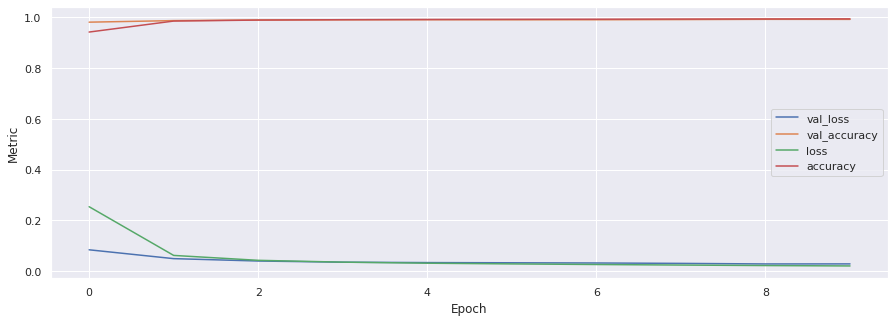

In [48]:
sns.set()
fig, ax = plt.subplots(figsize=(15,5))
history_df.plot(ax=ax)
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

# Evaluate

In [49]:
print('\n# Evaluate on test data')
results = classifier.evaluate(test_x, test_y)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")


# Evaluate on test data
2000/2000 [==============================] - 3s 1ms/step
loss: 0.030526427760720252
accuracy: 0.9913449883460999


## Confusion Matrix

In [50]:
def remap(matrix):
    """
    Utility function to take one-hot encoded labels and return the label with the higest probability
    """
    
    #Switch index to label
    def switcher(x):
        return dummyIndex_label_dict[x]
    
    #Get the index along the second axis (the one-hot encoding) with the highest value
    predicted_index = pd.DataFrame(np.argmax(matrix, axis=2))
    
    #Use our dictionary to map this index to the class
    label_representation = predicted_index.applymap(switcher)

    return label_representation

In [35]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

In [51]:
#Get the predicted classes for the test set
prediction_probabilities = classifier.predict(test_x)

predicted_classes = remap(prediction_probabilities)
true_classes = remap(test_y)

In [52]:
# Unravel it
predicted_classes = predicted_classes.values.reshape(-1,1)
true_classes = true_classes.values.reshape(-1,1)

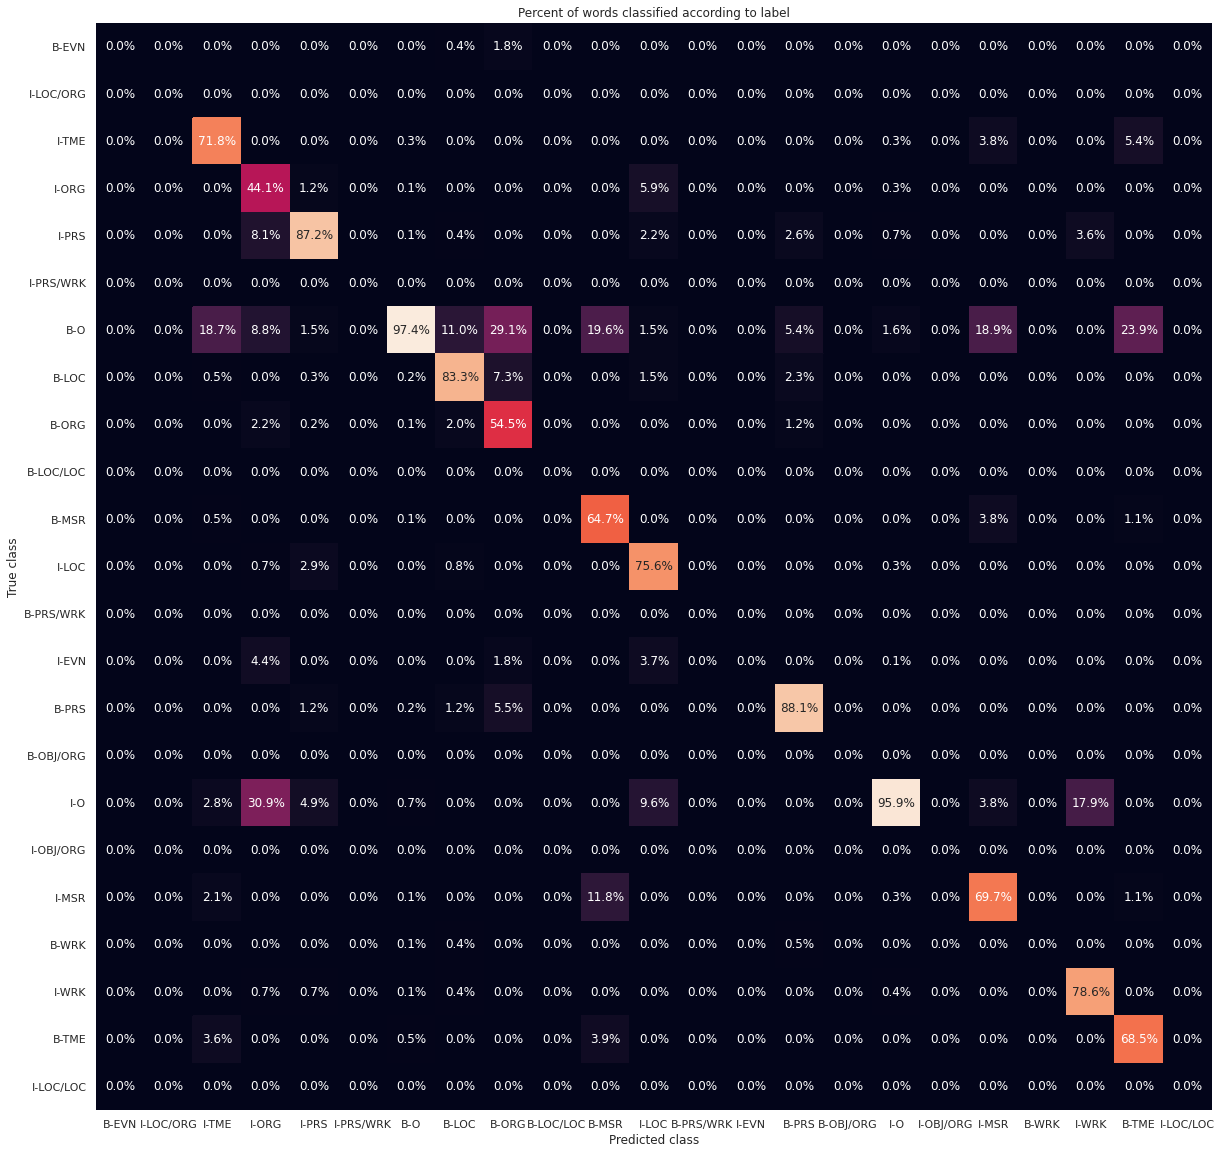

In [53]:
# The scikit confusion function also takes a list of labels. The generated confusion matrix will consist of the elements of this list, in the order they appear
cf_labels = list(dummyIndex_label_dict.values())

# We are great at padding, but that isn't super-interesting
cf_labels.remove('<pad>')
cf_labels.remove('[CLS]')
cf_labels.remove('[SEP]')
cf_labels.remove('B-LOC/ORG')
cf_labels.remove('B-LOC/PRS')
cf_labels.remove('I-LOC/PRS')

cf_labels.remove('B-ORG/PRS')
cf_labels.remove('I-OBJ')
cf_labels.remove('B-OBJ')

cf_labels.remove('I-ORG/PRS')




#Generate a confusion matrix
cmatrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes, labels = cf_labels)

#Use pandas for plotting purposes
cmatrix = pd.DataFrame(cmatrix, columns=cf_labels, index=cf_labels)

# The absolute number of things retrieved isn't as interesting as the relative retrival, so we normalize along the x-axis
cmatrix = cmatrix.apply(lambda x: x/x.sum(), axis = 0)

#Remove Nans
cmatrix = cmatrix.fillna(0)

#The confusion matrix is defined such that each row corresponds to a true label, each column is predicted label
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cmatrix, ax = ax, annot=True, fmt=".1%", cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.title("Percent of words classified according to label")
plt.show()

## Generate Recall, Precision, F1-score for each label

In [39]:
from sklearn.metrics import classification_report

report = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = cf_labels, output_dict=True, zero_division=0)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
B-EVN,0.000000,0.000000,0.000000,9.0
I-LOC/ORG,0.000000,0.000000,0.000000,0.0
I-TME,0.656398,0.695980,0.675610,398.0
I-ORG,0.403974,0.500000,0.446886,122.0
I-PRS,0.842434,0.868167,0.855107,622.0
I-PRS/WRK,0.000000,0.000000,0.000000,0.0
B-O,0.975905,0.983514,0.979694,29115.0
B-LOC,0.829365,0.735915,0.779851,284.0
B-ORG,0.500000,0.329412,0.397163,85.0
B-LOC/LOC,0.000000,0.000000,0.000000,0.0


## Test albert and classifier on single sentences

In [40]:
def format_single_sentence(s):
    """
    Takes a string and formats it for use with the ALBERT model used in this project
    Also returns the attention mask
    """
    pad_symbol = tokenizer.encode('<pad>', add_special_tokens=False)
    input_array = pad_symbol*100

    # Encode our sentence
    encoding = tokenizer.encode(s)

    #Overwrite our dummy array
    input_array[:len(encoding)] = encoding

    #Adjust dimensionality, make it a tensor
    input_tensor = torch.tensor(np.array(input_array).reshape(1,-1))
    
    attention = np.array(input_array) != 0
    attention_tensor = torch.tensor(attention.reshape(1,-1))
    return input_tensor, attention_tensor
    
#inp, att = format_single_sentence('hi')

In [41]:
def classify_single_sentence(sentence_tensor, attention_tensor):
    """
    Given input formatted for use with the ALBERT model, generates embeddings and uses them with a classifier to generate prediction for each original word
    Returns a dataframe containing token, predicted token, and certainity/probability
    """
    embedding = get_embeddings_with_gpu_batch(sentence_tensor, attention_tensor, 1)
    
    #Predict using the embeddings
    prediction_probabilities = classifier.predict(embedding)

    #Given these probabilities, get the predicted class for each word
    predicted_labels = remap(prediction_probabilities)

    #Get the confidence for our predictions as well
    certainity = prediction_probabilities.max(axis=2)

    #Get the input token array we used
    sentence_tokens = tokenizer.convert_ids_to_tokens(np.array(sentence_tensor).reshape(-1,))

    #Put it all into a dataframe for an easy-to-read output
    pretty_df = pd.DataFrame(columns = ['Word', 'Predicted_Label', 'Certainity'])

    pretty_df['Word'] = sentence_tokens
    pretty_df['Predicted_Label'] = predicted_labels.T
    pretty_df['Certainity'] = certainity.T
    
    return pretty_df

In [42]:
def NER(sentence):
    """
    Shorthand function for taken any sentence and tesing the model/classifier on it
    """
    sentence_tensor, attention_tensor = format_single_sentence(sentence)
    results = classify_single_sentence(sentence_tensor, attention_tensor)
    return results

In [43]:
s = "Oscuar Oscuarsson är en student på KTH sedan 2020, han studerar i Stockholm och arbetar med NER sedan några månader tillbaka"
#s = ""

NER(s).head(30)

100%|██████████| 1/1 [00:00<00:00, 25.69it/s]

Final embedding generated with shape (1, 100, 768)


,Word,Predicted_Label,Certainity
0,[CLS],[CLS],0.999683
1,▁Osc,B-PRS,0.471505
2,uar,I-PRS,0.895439
3,▁Osc,I-PRS,0.899120
4,uar,I-PRS,0.991028
5,sson,I-PRS,0.991857
6,▁är,B-O,0.997834
7,▁en,B-O,0.999877
8,▁student,B-O,0.998986
9,▁på,B-O,0.991533


## Test on sentence from SUC

In [44]:
#Select a sentence
select = 40

# Get the original sentence
sentence = np.array(sentences[select])
sentence_tokens = np.array(tokenizer.convert_ids_to_tokens(sentence))

# Get the ground truth labels
one_hot_truth = label_matrix[select].reshape(1,100,-1)
gt_labels = remap(one_hot_truth)

#Get the embedding matrix we generated for the sentence
sentence_embedding = embedding_matrix[select].reshape(1,100,-1)

#For each word, obtain the probabilities for each class
prediction_probabilities = classifier.predict(sentence_embedding)

#Given these probabilities, get the predicted class for each word
predicted_labels = remap(prediction_probabilities)

#Get the confidence for our predictions as well
certainity = prediction_probabilities.max(axis=2)


#Put it all into a dataframe for an easy-to-read output
pretty_df = pd.DataFrame(columns = ['Word', 'Predicted_Label', 'True_Label', 'Certainity'])

pretty_df['Word'] = sentence_tokens
pretty_df['Predicted_Label'] = predicted_labels.T
pretty_df['True_Label'] = gt_labels.T
pretty_df['Certainity'] = certainity.T


pretty_df.head(20)

,Word,Predicted_Label,True_Label,Certainity
0,[CLS],[CLS],[CLS],0.999838
1,▁Du,B-O,B-O,0.998800
2,▁måste,B-O,B-O,0.999745
3,▁alltså,B-O,B-O,0.998532
4,▁ha,B-O,B-O,0.999936
5,▁jobbat,B-O,B-O,0.999097
6,▁heltid,B-O,B-O,0.991215
7,▁i,B-TME,B-TME,0.534025
8,▁minst,B-TME,I-TME,0.458807
9,▁fyra,I-TME,I-TME,0.915749


In [ ]:
# Randomize train test split?

# A good read on using the fine-tuning approach
# https://medium.com/swlh/named-entity-recognition-using-bert-2fb924864d47

# Cross validated results

In [54]:
# Get the embedding matrix
embedding_matrix = get_embed_file()

# And the labels
label_matrix = get_label_file()

print(embedding_matrix.shape, label_matrix.shape)

(74165, 100, 768) (74165, 100, 33)


In [55]:
def get_data_from_disk(first, last):
    """
    Returns the sentence embeddings from indices first to last
    """
    return get_embed_file()[first:last,: , :], get_label_file()[first:last,: , :]

#a, b = get_data_from_disk(55,60)


In [56]:
def data_generator(batch_indices):
    """
    Generators are used to create data on the fly, without storing it in RAM.
    It's an iteration but with a function.
    It continously returns data.
    Though since we can't call return without cancelling the loop, generators use the keyword YIELD
    
    In our particular case, the function will yield batches of embedding matrices and 
    """
    for batch in batch_indices:
        start = batch[0]
        end = batch[1]
        yield get_data_from_disk(start, end)
        

In [57]:
def kfold_indices(n_splits, input_data):
    """
    Creates a list of indices to split on
    """
    input_length = input_data.shape[0]
    foldsize = int(np.ceil(input_length/n_splits))

    kfold_indices = []
    for i in range(n_splits):
        kfold_indices.append((i * foldsize, (i+1)*foldsize))
    return kfold_indices
    

splits = kfold_indices(100, label_matrix)
splits = splits[:5]
splits

[(0, 742), (742, 1484), (1484, 2226), (2226, 2968), (2968, 3710)]

In [58]:
"""
Overwriting the old one in order to get the correct shape
"""
def naive_bilstm_model():   
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(embedding_matrix.shape[1], embedding_matrix.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
            
    # add a timedistributed layer
    out = TimeDistributed(Dense(label_matrix.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

classifier = naive_bilstm_model()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 100, 33)           6633      
Total params: 701,833
Trainable params: 701,833
Non-trainable params: 0
_________________________________________________________________
None


### Resource for creating the generator
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [59]:
unique_labels = label_matrix.shape[2]
input_dim = (embedding_matrix.shape[1], embedding_matrix.shape[2])

In [66]:
import keras
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, shuffle=False):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        A common way to decide this is simply total amount of samples over batch size
        the batch size you can handle is, of course, determined by your computer, so set that accordingly
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        This function is responsible for grabbing the indices to load for each batch.
        And then calling the data generator for those ids
        """
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """
        If desired, shuffles the indices after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """
        This function brings data from disk into RAM.
        It is called once per batch, and thus brings in one batch of data.
        """
        X = get_embed_file()[list_IDs_temp,:,:]
        y = get_label_file()[list_IDs_temp,:,:]
        
        # We take the data at the specified indices and retrieve it
        return X, y


In [63]:
x.shape

(74165, 100, 768)

In [67]:

train_indices = [i for i in range(get_embed_file().shape[0])]
classifier = naive_bilstm_model()
dataGen = DataGenerator(train_indices)
classifier.fit_generator(generator=dataGen)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 100, 33)           6633      
Total params: 701,833
Trainable params: 701,833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
2317/2317 [==============================] - 265s 114ms/step - loss: 0.4406 - accuracy: 0.8670


In [68]:
classifier = naive_bilstm_model()

X = get_embed_file()[:5000,:,:]
y = get_label_file()[:5000,:,:]
classifier.fit(X, y, epochs = 5)


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 100, 33)           6633      
Total params: 701,833
Trainable params: 701,833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5000/5000 [==============================] - 20s 4ms/step - loss: 0.5530 - accuracy: 0.8478
Epoch 2/5
5000/5000 [==============================] - 16s 3ms/step - loss: 0.4359 - accuracy: 0.8694
Epoch 3/5
5000/5000 [==============================] - 16s 3ms/step - loss: 0.4270 - accuracy: 0.8709
Epoch 4/5
5000/5000 [==============================] - 16s 3ms/step - lo

In [ ]:
print('\n# Evaluate on test data')
results = classifier.evaluate(train_x, train_y)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")